In [9]:
import pandas as pd
import numpy as np
from scipy.stats import skew
import matplotlib.pyplot as plt
%matplotlib inline
#step1:reading csv data
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
#train.head()   # take a brief look at training data
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition'])) # concat training&test data

In [80]:
from scipy.stats import mode
# for numeric features, filling with mean(), for categorial features, filling with mode()[most common]
def mean_fill(df,attr):
    if df[attr].dtype == 'object':
        df[attr].fillna(mode(df[attr]).mode[0],inplace=True)
    else:
        df[attr].fillna(df[attr].mean(),inplace=True)
# #test for categorial feature
# mean_fill(all_data,'GarageCond')

In [85]:
from sklearn.ensemble import RandomForestRegressor
def randomforest_fill(df,attr):
    # get all the numeric features to predict the missing value, because
    # that sklearn's random forest algo can only handle numeric features.
    # It could be better to transform the categorial features before calling this method
    numeric_df = all_data.loc[:,all_data.isnull().any().values==False].select_dtypes(include = ['float64','int64'])
    numeric_df[attr]=df[attr]
    numeric_df_notnull = numeric_df.loc[(df[attr].notnull())]
    numeric_df_isnull = numeric_df.loc[(df[attr].isnull())]
    X = numeric_df_notnull.drop(attr,axis=1)
    Y = numeric_df_notnull[attr]
    # use RandomForest to train data
    clf = RandomForestRegressor(n_estimators = 1000, n_jobs = -1) # n_jobs:The number of jobs to run in parallel for both fit and predict. If -1, then the number of jobs is set to the number of cores
    clf.fit(X,Y)
    predicted_attr = clf.predict(numeric_df_isnull.drop(attr,axis=1))
    df.loc[(df[attr].isnull()),attr] = predicted_attr

#randomforest_fill(all_data,'MasVnrArea')
## before filling the missing value
#all_data.loc[234]['MasVnrArea']
''' # output
234    NaN
234    0.0
Name: MasVnrArea, dtype: float64
'''
## after filling the missing value
#all_data.loc[234]['MasVnrArea']
''' # output 
234    82.882
234     0.000
Name: MasVnrArea, dtype: float64
'''

' # output \n234    82.882\n234     0.000\nName: MasVnrArea, dtype: float64\n'

In [93]:
# treat the missing value as a different value
def ano_value_for_miss(df,attr):
    df[attr].fillna('No_value',inplace=True)

## test
# ano_value_for_miss(all_data, 'Alley')

In [90]:
# data normalization for numeric feature
# whether to use this method depends on the model used
# if distance based model is used, then u need to call this 
# It seems that the popular model Xgbost doesnt need normalization
def normalization(df,attr):
    # filled when used
    pass

In [2]:
# get dummies for one categorial feature
def dummy_one(df,attr):
    h_dummies = pd.get_dummies(df[attr],prefix=attr)
    df.drop([attr],axis=1,inplace=True)
    df = df.join(h_dummies)
    return df
# all_data = dummy_one(all_data, 'Alley')    
 
# get dummies for all categorial features in df
def dummy_all(df):
    df = pd.get_dummies(df)
    return df
#all_data = dummy_all(all_data)
#all_data.info(verbose=True,max_cols=1000)

In [45]:
from scipy.stats import skew
# Attetion here: for log transform to make features more normally distributed and 
# this makes linear regression preform better, since linear regression is sensitive to outliers.
# But!! ! note that if a tree-based model is used, then this log transform is not necessary.
# In a word, many preprecessing steps must be contacted to ur model used.

# the predict object or features could be skewed, we can do log tansform for those variables
# do log transform for one feature/target
# threshold: determine whether to do log transform on this feature/target
def log_skewed_one(df, attr, threshold):
    # calculate the skewness
    skewness = skew(df[attr].dropna())
    if skewness > threshold:
        df[attr] = np.log1p(df[attr])
#log_skewed_one(train, 'SalePrice', 0.75)
#train['SalePrice'].hist()

def log_skewed_all(df,threshold):
    # get index of all numeric features
    numeric_feats = df.dtypes[df.dtypes != 'object'].index
    # then compute the skewness for each features
    skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna()))
    # get the features whose skeness>0.75
    skewed_feats = skewed_feats[skewed_feats>threshold]
    skewed_feats = skewed_feats.index
    df[skewed_feats] = np.log1p(df[skewed_feats])
#log_skewed_all(train,0.75)
#train['SalePrice'].hist()

In [100]:
from sklearn.decomposition import PCA
# Note that the input df must not have categorial features or missing value,
# do this after preprocessing fo filling missing value and feature transformation
def pca_reduc(df, num_fea_toleave='mle'):
    # @return type: pd.DataFrame
    pca = PCA(n_components=num_fea_toleave)
    after_pca = pca.fit_transform(df)
    print 'Percentage of variance explained by each of the selected components:'
    print(pca.explained_variance_ratio_)
    #print pd.DataFrame(new).info()
    return pd.DataFrame(after_pca)
#all_data = dummy_all(all_data)
#all_data.fillna(all_data.mean(),inplace=True)
#all_data = pca_reduc(all_data,30)
#all_data.info(verbose=True, max_cols=1000)

In [101]:
from sklearn.decomposition import KernelPCA
# Kernel PCA ==> non-linear dimensionality reduction through the use of kernels
# Somewhat like kernel in SVM
# kernel = “linear” | “poly” | “rbf” | “sigmoid” | “cosine” | “precomputed”
def kernelpca_reduc(df, kernel='linear',num_fea_toleave=50):
    kpca = KernelPCA(n_components=num_fea_toleave,kernel = kernel,n_jobs=-1)
    after_kpca = kpca.fit_transform(df)
    print 'the selected features Eigenvalues in decreasing order:'
    print (kpca.lambdas_)
    return pd.DataFrame(after_kpca)
#all_data = dummy_all(all_data)
#all_data.fillna(all_data.mean(),inplace=True)
#all_data = kernelpca_reduc(all_data,kernel='rbf',num_fea_toleave=50)
#print all_data.shape

In [10]:
from sklearn.decomposition import TruncatedSVD
# Dimensionality reduction using truncated SVD
def truncatedSVD_reduc(df,num_fea_toleave=50):
    # provide a random_state to get stable output
    svd = TruncatedSVD(n_components=num_fea_toleave, n_iter=7, random_state=42)
    after_trans = svd.fit_transform(df)
    print 'Percentage of variance explained by each of the selected components:'
    print(svd.explained_variance_ratio_) 
    return pd.DataFrame(after_trans)
#all_data = dummy_all(all_data)
#all_data.fillna(all_data.mean(),inplace=True)
#all_data = truncatedSVD_reduc(all_data,num_fea_toleave=50)
#print all_data.shape

Optimal number of features : 1


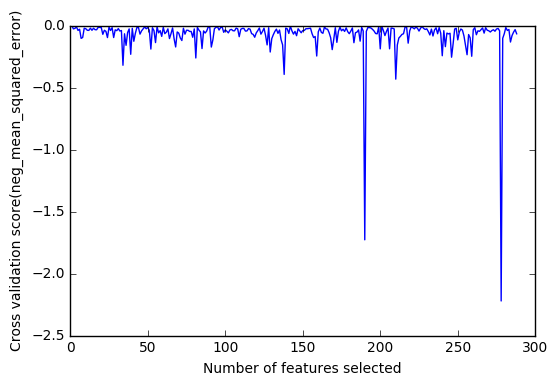

In [16]:
from sklearn.feature_selection import RFECV
def fea_sel_rfecv(train_x,train_y,estimator):
    rfecv = RFECV(estimator=estimator,scoring='neg_mean_squared_error',n_jobs=-1)
    rfecv.fit(train_x,train_y)
    print("Optimal number of features : %d" % rfecv.n_features_)
    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score(neg_mean_squared_error)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
#train = dummy_all(train)
#train.fillna(train.mean(),inplace=True)
#from sklearn import svm
#clf = svm.LinearSVR()
#fea_sel_rfecv(train.iloc[:,1:-1],train['SalePrice'],clf)

In [10]:
from sklearn.feature_selection import SelectFromModel
# u can see from 'SelectFromModel' that this method use model result to select features, 'Wrapper'
# estimator: a supervised model with fit() method
def fea_sel_tree(train_x,train_y,estimator):
    estimator = estimator.fit(train_x,train_x)
    print 'feature importances in this model',
    print sorted(estimator.feature_importances_,reverse=True)
    model = SelectFromModel(estimator,prefit = True)
    after_sel = model.transform(train_x)
    return pd.DataFrame(after_sel)
#train = dummy_all(train)
#train.fillna(train.mean(),inplace=True)
#from sklearn.ensemble import RandomForestRegressor
#clf = RandomForestRegressor(random_state=0,n_estimators=50)
#print fea_sel_tree(train.iloc[:,1:-1],train['SalePrice'],clf).shape

feature importances in this model [0.98000781452918662, 0.0053984908681043494, 0.001102063486300951, 0.00074209174757163942, 0.00068996210853836961, 0.00066708030615678549, 0.0006489626403154826, 0.00050391734372790822, 0.00049315943905588796, 0.00047094000671370277, 0.00044153876920138271, 0.00041722192715090597, 0.00036745768418134083, 0.0003381357413881645, 0.0003341630614274668, 0.00032345761117464456, 0.00029386284520929463, 0.00028566603118128435, 0.00028267497504087661, 0.00027649037526597824, 0.00027644801294989424, 0.00026599671156190196, 0.00026506697130850373, 0.00024953197896268164, 0.00023652909262425269, 0.00022003325549557556, 0.00019913031366764828, 0.00019433459285007253, 0.00019201461150636725, 0.00017186175900870429, 0.00017026584523794277, 0.00015536757618660196, 0.00013487752692866118, 0.00013297787614234116, 0.00012547724533254178, 0.0001236218884256175, 0.00011570667662910186, 0.00010254979122568836, 0.00010249541458522161, 9.8818058643856211e-05, 9.6454218642988

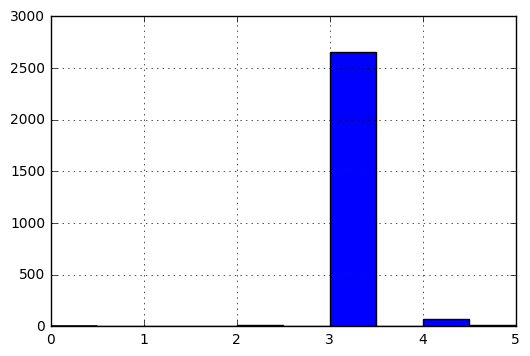

In [99]:
# flag: GarageCond属性值实际有值的很少
all_data['GarageCond'].map({'Ex':0,'Gd':2,'TA':3,'Fa':4,'Po':5,'NA':6}).hist()